# Checkpoint 3
## KNN

In [74]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv

--2023-10-19 23:20:18--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9788953 (9.3M) [text/plain]
Saving to: ‘hotels_train.csv.1’

hotels_train.csv.1  100%[===================>]   9.33M  --.-KB/s    in 0.07s   

2023-10-19 23:20:19 (136 MB/s) - ‘hotels_train.csv.1’ saved [9788953/9788953]



In [75]:
!wget https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv

--2023-10-19 23:20:19--  https://raw.githubusercontent.com/dlevi150/7506R-2C2023-GRUPO33/main/CHP1/datasets/hotels_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4432981 (4.2M) [text/plain]
Saving to: ‘hotels_test.csv.1’

hotels_test.csv.1   100%[===================>]   4.23M  --.-KB/s    in 0.06s   

2023-10-19 23:20:20 (73.1 MB/s) - ‘hotels_test.csv.1’ saved [4432981/4432981]



In [76]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import DistanceMetric
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [77]:
df = pd.read_csv("hotels_train.csv")

df_filtrado = df.copy()

# Modificando el dataset

In [78]:
df_filtrado = df_filtrado.drop('id', axis=1)

In [79]:
months_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

def mapear_mes_a_numero(fecha):
    if(np.nan == fecha):
        return -1
    return months_dict.get(fecha)

df_filtrado['arrival_date_month'] = df_filtrado['arrival_date_month'].apply(mapear_mes_a_numero)


formato_fecha = "%Y-%m-%d"

df_filtrado['date'] = pd.to_datetime(df_filtrado[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str).agg('-'.join, axis=1), format=formato_fecha)
df_filtrado['ordinal date'] = df_filtrado.date.apply(lambda x: x.toordinal())
df_filtrado.drop('date',axis=1, inplace=True)
df_filtrado.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled,ordinal date
0,City Hotel,49,2016,9,37,5,1,2,1,0.0,...,No Deposit,9.0,NaN,0,Transient,115.5,0,1,1,736212
1,Resort Hotel,4,2015,10,44,31,0,1,2,0.0,...,No Deposit,NaN,NaN,0,Transient,42.0,1,0,0,735902


In [80]:
df_filtrado.children = df_filtrado.children.replace(np.nan, 0)
df_filtrado.agent = df_filtrado.agent.replace(np.nan, -1)
df_filtrado.company = df_filtrado.company.replace(np.nan, -1)
df_filtrado['country'] = df_filtrado['country'].replace(np.nan, 'PRT')

In [81]:
df_filtrado['country'] = df_filtrado['country'].replace(np.nan, 'PRT')

In [82]:
df_filtrado = df_filtrado.replace({'adults': 0}, value=2)
df_filtrado = df_filtrado.replace({'children': 10}, value=0)
df_filtrado = df_filtrado.replace({'babies': 9}, value=0)
df_filtrado = df_filtrado.replace({'adr': -6.38}, value=df_filtrado['adr'].median())
df_filtrado = df_filtrado.replace({'adr': 0}, value=df_filtrado['adr'].median())

# Encoding and separation columns

Usando una prroporción de 70 y 30 separo mi dataset en train y validation.

In [83]:
ds_encodeado = pd.get_dummies(df_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type", "agent", "company"], drop_first=True)
ds_encodeado.head(3)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,company_512.0,company_515.0,company_521.0,company_523.0,company_525.0,company_528.0,company_530.0,company_539.0,company_541.0,company_543.0
0,49,2016,37,5,1,2,1,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,2015,44,31,0,1,2,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25,2016,42,13,0,1,2,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
ds_trabajo_x=ds_encodeado.drop(['is_canceled'], axis='columns', inplace=False)

ds_trabajo_y = ds_encodeado['is_canceled'].copy()

x_train, x_valid, y_train, y_valid = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=0)

# Entrenamiento y predicción

#Busqueda de hiperparametros

todas las distancias que usa cada algoritmo

In [85]:
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

#Métricas Válidas
VALID_METRICS = dict(
    ball_tree=BallTree.valid_metrics,
    kd_tree=KDTree.valid_metrics,
    # The following list comes from the sklearn.metrics.pairwise doc string
    brute=list(PAIRWISE_DISTANCE_FUNCTIONS.keys())
    + [ 'braycurtis','canberra','chebyshev','correlation',
        'cosine','dice','hamming','jaccard','kulsinski',
        'mahalanobis','matching','minkowski','rogerstanimoto',
        'russellrao','seuclidean','sokalmichener','sokalsneath',
        'sqeuclidean','yule','wminkowski',
    ],
)

#Ejemplo
for alg in VALID_METRICS:
    print(f'algoritmo: {alg}')
    print(VALID_METRICS[alg])
    print()

algoritmo: ball_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity', 'seuclidean', 'mahalanobis', 'wminkowski', 'hamming', 'canberra', 'braycurtis', 'matching', 'jaccard', 'dice', 'kulsinski', 'rogerstanimoto', 'russellrao', 'sokalmichener', 'sokalsneath', 'haversine', 'pyfunc']

algoritmo: kd_tree
['euclidean', 'l2', 'minkowski', 'p', 'manhattan', 'cityblock', 'l1', 'chebyshev', 'infinity']

algoritmo: brute
['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski']



randomized

In [86]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

#Cantidad de combinaciones que quiero porbar
n=5

#Conjunto de parámetros que quiero usar
params_grid={ 'n_neighbors':range(1,30),
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree'],#le saque brute porque mas de 1 h ya
              'metric':['euclidean','manhattan','chebyshev']
             }


#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
knn=KNeighborsClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=knn,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=2)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

In [87]:
#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'weights': 'distance', 'n_neighbors': 24, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
0.7703103364530808


aca abajo copie y pegue tal cual el entrenamiento y prediccion, solo por no querer tocarlo

In [107]:
knn_model = KNeighborsClassifier(n_neighbors=randomcv.best_params_['n_neighbors'],
                                         weights = randomcv.best_params_['weights'],
                                         algorithm=randomcv.best_params_['algorithm'],
                                         metric=randomcv.best_params_['metric'])
#Entrenamos el modelo
model = knn_model.fit(X = x_train.sort_index(axis=1), y = y_train)

In [108]:
y_pred = model.predict(x_valid.sort_index(axis=1))
#Valores Predichos
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [109]:
ds_resultados=pd.DataFrame(zip(y_valid,y_pred),columns=['test','pred'])
ds_resultados.head(10)

,test,pred
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,0,0
7,1,1
8,0,0
9,1,1


Text(50.722222222222214, 0.5, 'True')

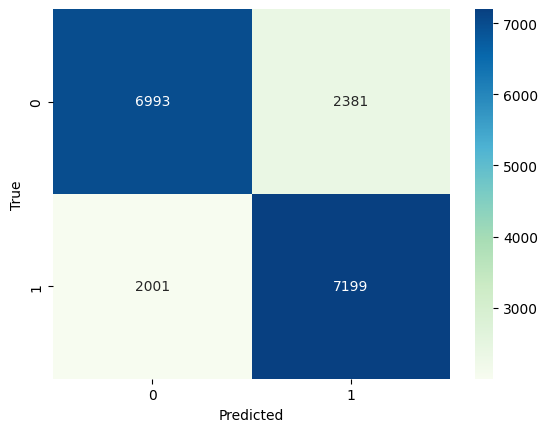

In [110]:
tabla=confusion_matrix(y_valid, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [111]:
accuracy=accuracy_score(y_valid,y_pred)
recall=recall_score(y_valid,y_pred)
f1=f1_score(y_valid,y_pred,)
precision=precision_score(y_valid,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7640788198557122
Recall: 0.7825
Precision: 0.7514613778705637
f1 score: 0.7666666666666666


In [112]:
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76      9374
           1       0.75      0.78      0.77      9200

    accuracy                           0.76     18574
   macro avg       0.76      0.76      0.76     18574
weighted avg       0.76      0.76      0.76     18574



# Test prediction

## Modificando el Dataset

In [113]:
df_test = pd.read_csv("hotels_test.csv")

df_test_filtrado = df_test.copy()

In [114]:
months_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

def mapear_mes_a_numero(fecha):
    if(np.nan == fecha):
        return -1
    return months_dict.get(fecha)

df_test_filtrado['arrival_date_month'] = df_test_filtrado['arrival_date_month'].apply(mapear_mes_a_numero)


formato_fecha = "%Y-%m-%d"

df_test_filtrado['date'] = pd.to_datetime(df_test_filtrado[['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month']].astype(str).agg('-'.join, axis=1), format=formato_fecha)
df_test_filtrado['ordinal date'] = df_test_filtrado.date.apply(lambda x: x.toordinal())
df_test_filtrado.drop('date',axis=1, inplace=True)
df_test_filtrado.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,id,ordinal date
0,City Hotel,277,2016,11,46,7,1,2,2,0.0,...,NaN,NaN,0,Transient,100.0,0,0,2016-04-04,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,736275
1,City Hotel,286,2016,5,20,11,0,4,2,0.0,...,30.0,NaN,176,Transient-Party,101.0,0,0,2016-01-22,aba9aac2-4495-4645-a60e-90328713c999,736095


In [115]:
df_test_ids = df_test['id']
df_test_filtrado = df_test_filtrado.drop('id', axis=1)
df_test_filtrado = df_test_filtrado.drop('reservation_status_date', axis=1)

In [116]:
df_test_filtrado['country'] = df_test_filtrado['country'].replace(np.nan, 'PRT')
df_test_filtrado.agent = df_test_filtrado.agent.replace(np.nan, -1)
df_test_filtrado.company = df_test_filtrado.company.replace(np.nan, -1)
df_test_filtrado.children = df_test_filtrado.children.replace(np.nan, 0)

In [117]:
df_test_filtrado.isna().any()

hotel                             False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                             False
company                           False
days_in_waiting_list              False


Tratamos de eliminar los paises que solo aparecen en el set de test y no en el de train.

In [118]:
lista_paises_unicos_test = df_test_filtrado['country'].unique()
lista_paises_unicos = df_filtrado['country'].unique()
conjunto1 = set(lista_paises_unicos)
conjunto2 = set(lista_paises_unicos_test)


# Obtener los elementos que están en conjunto1 pero no en conjunto2
elementos_en_lista1_no_en_lista2 = list(conjunto2 - conjunto1)
print(elementos_en_lista1_no_en_lista2)

df_test_filtrado["country"] = df_test_filtrado["country"].replace(to_replace=elementos_en_lista1_no_en_lista2, value="PRT")

['NIC', 'MLI', 'SLV', 'KHM', 'DJI', 'BFA', 'ASM', 'SMR', 'UZB', 'ATF', 'DMA', 'TMP']


In [119]:
df_test_filtrado["adr"] = df_test_filtrado["adr"].replace(to_replace=0, value=df_filtrado['adr'].median())
df_test_filtrado["adults"] = df_test_filtrado["adults"].replace(to_replace=0, value=2)

In [120]:
df_test_encodeado = pd.get_dummies(df_test_filtrado, columns=["hotel", "arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","assigned_room_type","deposit_type", "customer_type", "agent", "company"], drop_first=True)


## Prediccion

In [121]:
lista = df_test_encodeado.columns
columnas_faltantes = []
for colum in ds_encodeado.columns:
  if(colum not in lista and colum != "is_canceled"):
    print(colum)
    columnas_faltantes.append(colum)

for colum_faltante in columnas_faltantes:
  df_test_encodeado[colum_faltante] = 0

country_ARM
country_AZE
country_BEN
country_CIV
country_COM
country_ETH
country_FJI
country_FRO
country_GTM
country_HND
country_KEN
country_KNA
country_MDG
country_MNE
country_MUS
country_MYT
country_NAM
country_PAN
country_PYF
country_SDN
country_SYC
country_SYR
country_TGO
country_UMI
country_VGB
country_ZMB
market_segment_Undefined
distribution_channel_Undefined
assigned_room_type_L
agent_24.0
agent_59.0
agent_93.0
agent_107.0
agent_114.0
agent_144.0
agent_167.0
agent_173.0
agent_179.0
agent_197.0
agent_214.0
agent_244.0
agent_247.0
agent_265.0
agent_267.0
agent_270.0
agent_278.0
agent_283.0
agent_289.0
agent_291.0
agent_299.0
agent_301.0
agent_302.0
agent_304.0
agent_321.0
agent_333.0
agent_352.0
agent_388.0
agent_391.0
agent_404.0
agent_405.0
agent_414.0
agent_416.0
agent_418.0
agent_427.0
agent_430.0
agent_431.0
agent_432.0
agent_438.0
agent_441.0
agent_449.0
agent_450.0
agent_451.0
agent_455.0
agent_461.0
agent_472.0
agent_476.0
agent_481.0
agent_483.0
agent_497.0
agent_509.0
ag

<ipython-input-121-e1f11acae15e>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_encodeado[colum_faltante] = 0
<ipython-input-121-e1f11acae15e>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_encodeado[colum_faltante] = 0
<ipython-input-121-e1f11acae15e>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

In [122]:
lista = ds_encodeado.columns
columnas_a_eliminar = []
for colum in df_test_encodeado.columns:
  if(colum not in lista):
    print(colum)
    columnas_a_eliminar.append(colum)

df_test_encodeado = df_test_encodeado.drop(columns=columnas_a_eliminar)

agent_122.0
agent_135.0
agent_150.0
agent_165.0
agent_211.0
agent_213.0
agent_232.0
agent_282.0
agent_331.0
agent_337.0
agent_358.0
agent_363.0
agent_367.0
agent_397.0
agent_444.0
agent_469.0
agent_510.0
company_6.0
company_11.0
company_35.0
company_52.0
company_61.0
company_64.0
company_71.0
company_77.0
company_102.0
company_142.0
company_146.0
company_158.0
company_165.0
company_185.0
company_210.0
company_224.0
company_253.0
company_257.0
company_304.0
company_309.0
company_314.0
company_386.0
company_410.0
company_411.0
company_422.0
company_444.0
company_454.0
company_478.0
company_482.0
company_491.0
company_494.0
company_506.0
company_513.0
company_514.0
company_516.0
company_518.0
company_531.0
company_534.0


In [123]:
test_pred_2 = model.predict(df_test_encodeado.sort_index(axis=1))
test_pred_2

array([1, 1, 0, ..., 0, 0, 0])

In [124]:
data = {'id': df_test_ids, 'is_canceled': test_pred_2}
df_final_finalisimo = pd.DataFrame(data)

In [125]:
df_final_finalisimo.isna().any()

id             False
is_canceled    False
dtype: bool

In [126]:
df_final_finalisimo.to_csv('submission.csv', index=False)
